In [1]:
import os
import sys

from itertools import product

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt

from utils.dataset import train_test_load
from utils.checkpoint import save_params

from model.train.recommender import training_loop
from model.train.recommender_feature import training_loop as training_loop_feat

In [2]:
test_split = 0.2

train, test = train_test_load("../data/ml-32m/ratings.csv", "../data/ml-32m/movies.csv", test_split=test_split)

### Training

In [11]:
records = []

embedds = [0, 1, 2, 5, 10, 20]
lambdas = [0.01, 0.1, 0.5]
gammas  = [0.01, 0.1, 0.5]
taus    = [0.01, 0.1, 0.5]

for emb, lmb, tau, gam in product(embedds, lambdas, taus, gammas):
    hyper_params = {
        'embedding_dim': emb,
        'r_lambda': lmb,
        'r_gamma': tau,
        'r_tau': gam,
    }

    train_loss, train_rmse, test_loss, test_rmse, _, _, _, _ = training_loop(
        train.user_movies, train.movie_users, test.user_movies, test.movie_users,
        n_iter = 15, **hyper_params
    )
        
    records.append((hyper_params, train_rmse[-1]))

In [18]:
print("Best Hyperparameter per embedding size")

for e in embedds:
    hyper_param, loss = min(filter(lambda x: x[0]['embedding_dim'] == e, records), key=lambda x: x[1])
    print(f"Embedding size {e}: {hyper_param} - {loss:.2f}")

Best Hyperparameter per embedding size
Embedding size 0: {'embedding_dim': 0, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.5} - 0.85
Embedding size 1: {'embedding_dim': 1, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.01} - 0.81
Embedding size 2: {'embedding_dim': 2, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.01} - 0.79
Embedding size 5: {'embedding_dim': 5, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.1} - 0.74
Embedding size 10: {'embedding_dim': 10, 'r_lambda': 0.1, 'r_gamma': 0.01, 'r_tau': 0.01} - 0.70
Embedding size 20: {'embedding_dim': 20, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.1} - 0.64


In [3]:
hyper_params = {'embedding_dim': 2, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.01}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

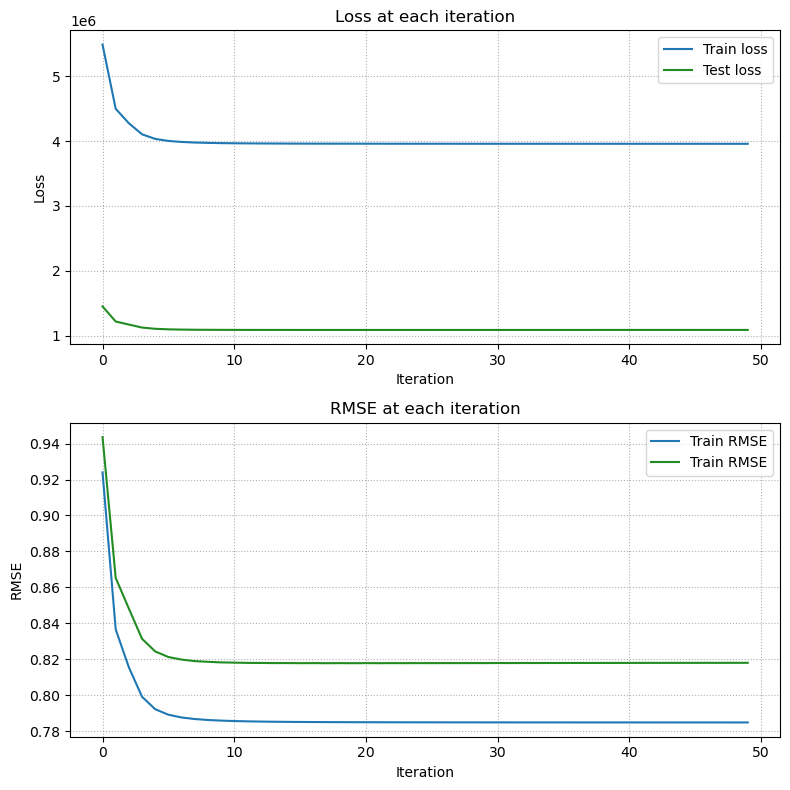

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_2.svg", format="svg")
plt.show()

In [5]:
save_params(
    "../artifacts/model/32m_users_training_2", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

In [6]:
hyper_params = {'embedding_dim': 10, 'r_lambda': 0.1, 'r_gamma': 0.01, 'r_tau': 0.01}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

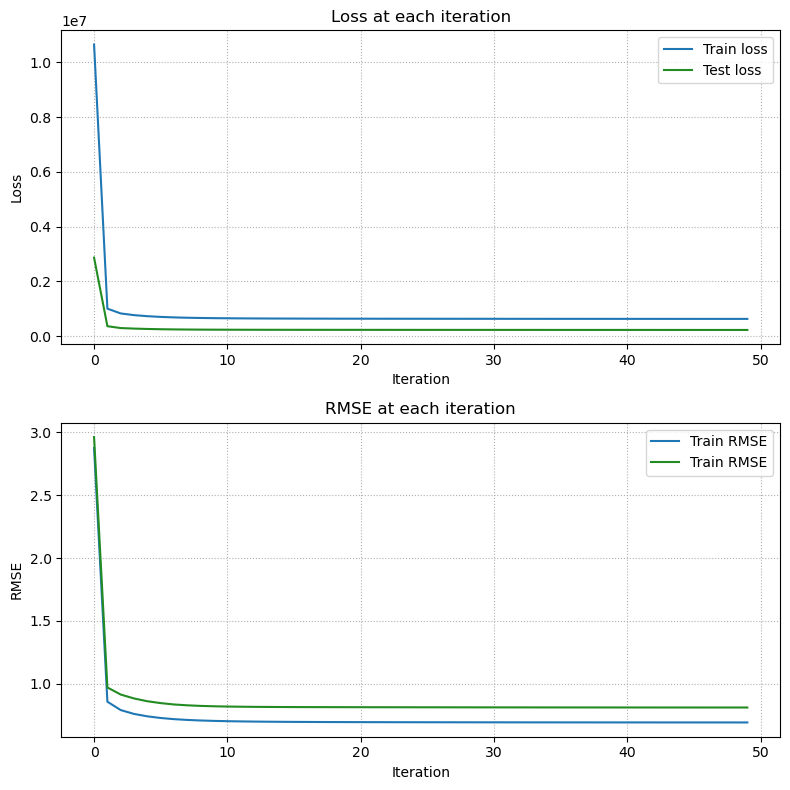

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_10.svg", format="svg")
plt.show()

In [8]:
save_params(
    "../artifacts/model/32m_users_training_10", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

In [9]:
hyper_params = {'embedding_dim': 20, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.1}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

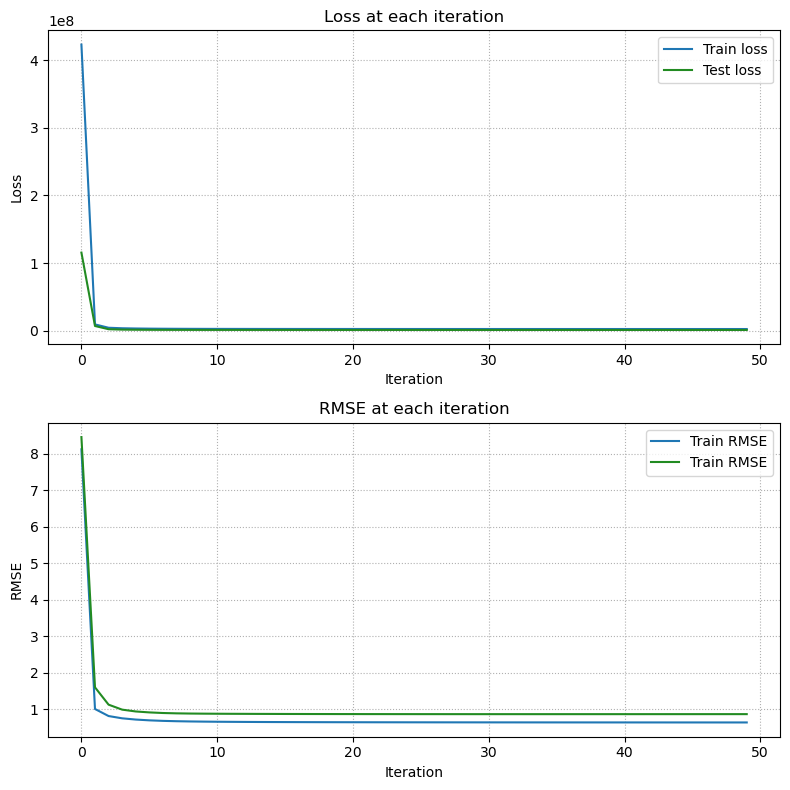

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_20.svg", format="svg")
plt.show()

In [11]:
save_params(
    "../artifacts/model/32m_users_training_20", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

In [4]:
# Arbitrary Hyperparameter Choice

hyper_params = {'embedding_dim': 20, 'r_lambda': 0.1, 'r_gamma': 0.1, 'r_tau': 0.1}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [5]:
save_params(
    "../artifacts/model/32m_users_training_choice", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

In [6]:
hyper_params = {'embedding_dim': 2, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.01}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

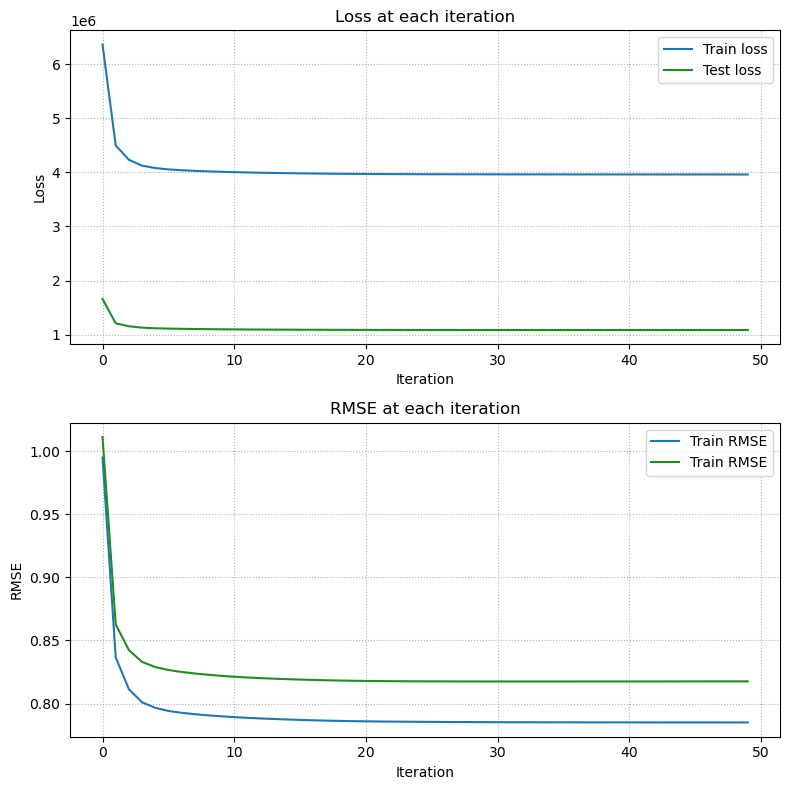

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_2.svg", format="svg")
plt.show()

In [8]:
save_params(
    "../artifacts/model/32m_users_training_features_2", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

In [6]:
hyper_params = {'embedding_dim': 20, 'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.1}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

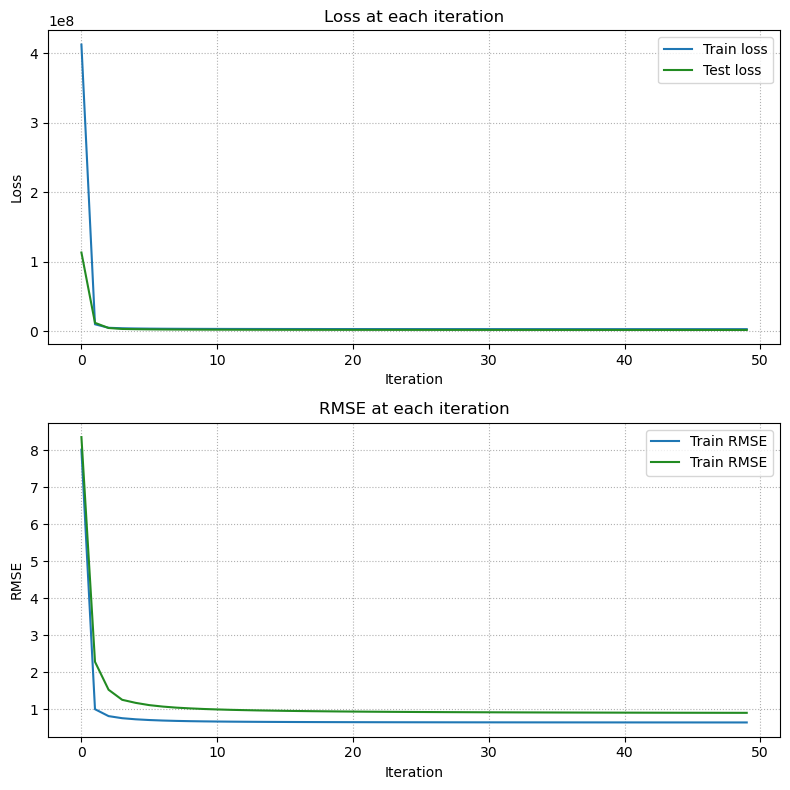

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_20.svg", format="svg")
plt.show()

In [10]:
save_params(
    "../artifacts/model/32m_users_training_features_20", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

---